# Table of Contents
 <p>

In [54]:
# system level
import sys

# arrays
import numpy as np

# keras
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

# sklearn (for machine learning)
from sklearn import metrics

# plotting
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import seaborn as sns


# theano
import theano
print "CONFIG:", theano.config.device

CONFIG: cpu


In [80]:
# utility plots
def remove_tick_labels(axis):
    """Remove tick labels."""
    axis.set_xticklabels([])
    axis.set_yticklabels([])

    for tl in axis.xaxis.get_major_ticks():
        tl.tick1On = tl.tick2On = False
    for tl in axis.yaxis.get_major_ticks():
        tl.tick1On = tl.tick2On = False

def make_mosaic(imgs, nrows, ncols, border=1):
    """Make a nice mosaic.

    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols;
    intended for use with activation layer
    """
    # set up data
    nimgs = imgs.shape[0]
    imshape = imgs.shape#[1:]
    print nimgs, imgs.shape, imshape

    mosaic = np.ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                           ncols * imshape[1] + (ncols - 1) * border),
                           dtype=np.float32)

    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols

        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None, norm=None):
    """Image plot."""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    remove_tick_labels(ax)
    im = ax.imshow(data, vmin=vmin, vmax=vmax,
                   #interpolation='nearest',
                   cmap=cmap,
                   norm=norm)
    plt.colorbar(im, cax=cax)

def get_layers(model, data,
                 version_data,
                 ind_layer_in=0,
                 ind_layer_out=0):
    """Recall activation layer information."""
    data_sets = {"train": 0, "test": 1}
    layer_input = model.layers[ind_layer_in].input
    layer_output = K.function([layer_input, K.learning_phase()],
                              [model.layers[ind_layer_out].output])
    layer_outputs = layer_output([data, data_sets[version_data]])[0]

    return layer_outputs    
    
def plot_layer_filter_panel(
                             layer,
                             ind_obj_choice,
                             n_img_y=6,
                             n_img_x=6):
                             
    """Plot: result of a layer; all filters."""
    # style
    #plt.style.use(dir_style + 'deeplensing.mplstyle')
    #sns.set_palette("coolwarm", n_colors=6)
    #n_colors = 300
    #cmap = sns.color_palette("coolwarm", n_colors=n_colors)#, color_codes=True)
    #cmap = ListedColormap(cmap)

    layer_object = layer[ind_obj_choice]
    # layer_object = layer_object + np.abs(np.min(layer_object))+1.0
    c1 = np.squeeze(layer_object)

    # plot
    plt.figure(figsize=(12, 12))
    #plt.grid(False)
    nice_imshow(plt.gca(), make_mosaic(c1, n_img_x, n_img_y), vmin=-120, xmax=40, cmap=cmap) #, norm=LogNorm())

    return 

In [30]:
# ------------------------------------------------------------------------------
# Input variables
# ------------------------------------------------------------------------------

# training variables
nb_train = 1000
nb_valid = 1000
nb_test = 1000
nb_epoch = 10
nb_classes = 2
batch_size = 32
shuffle = True

# data locations
dir_test = "/Users/nord/Dropbox/deeplensing/Data/Simulation/SimLensPop/Data097/"
file_x_data = dir_test + "xtrain_lenspop.npy" # x data (images)
file_y_data = dir_test + "ytrain_lenspop.npy" # y data (labels)
file_lens_data = dir_test + "lenspars_set.npy" # lens data (physical parameters of lenses/non-lenses)
f_model = dir_test + "model.json" # model data (architecture)
f_weights = dir_test + "weights.h5" # model data (weights that we fit for)

In [53]:
# ------------------------------------------------------------------------------
# Read in Data
# ------------------------------------------------------------------------------

# load data
x_data = np.load(file_x_data)
y_data = np.load(file_y_data)
lens_data = np.load(file_lens_data)

# check data sizes
statement =  "#TrainingSamples + #ValidSamples #TestSamples > TotalSamples, exiting!!!"
nb_total = nb_train + nb_test + nb_valid
assert nb_total <= len(x_data), statement

# indices for where to slice the arrays
ind_valid_start = ind_train_end = nb_train
ind_valid_end = ind_test_start = nb_train + nb_valid
ind_test_end = nb_train + nb_valid + nb_test

# slice the image arrays
x_train = x_data[:ind_train_end, :, :, :]
x_valid = x_data[ind_valid_start: ind_valid_end, :, :, :]
x_test = x_data[ind_test_start: ind_test_end, :, :, :]

# slice the label arrays
y_train = y_data[:ind_train_end]
y_valid = y_data[ind_valid_start: ind_valid_end]
y_test = y_data[ind_test_start: ind_test_end]

# cast data types
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')


print "Data dimensions: "
print "Input data: ", np.shape(x_data), np.shape(y_data)
print "Training set: ", np.shape(x_train), np.shape(y_train)
print "Validation set: ", np.shape(x_valid), np.shape(y_valid)
print "Test Set: ", np.shape(x_test), np.shape(y_test)
print


NameError: name 'file_lens_data' is not defined

In [32]:
# ------------------------------------------------------------------------------
# generate the model architecture
# example: shallow res (enter link to reference)
# ------------------------------------------------------------------------------

# Define architecture for model
data_shape = np.shape(x_data)
input_shape = (3, 64, 64)
x = Input(shape=input_shape)
c0 = Convolution2D(32, 3, 3, activation='softplus', subsample=(4, 4), border_mode='same', dim_ordering='th')(x)
b0 = BatchNormalization()(c0)
d0 = Dropout(0.5)(b0)
c1 = Convolution2D( 8, 3, 3, activation='softplus', subsample=(2, 2), border_mode='same')(d0)
b1 = BatchNormalization()(c1)
d1 = Dropout(0.5)(b1)
f = Flatten()(d1)
z0 = Dense(128, activation='softplus')(f)
z1 = Dense(32, activation='softplus')(z0)
y = Dense(1, activation='sigmoid')(z1)
model = Model(input=x, output=y)

# Compile Model
optimizer = 'adadelta'
metrics = ['accuracy']
loss = 'binary_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [33]:
# ------------------------------------------------------------------------------
# Train model
# ------------------------------------------------------------------------------

# Train 
history = model.fit(
                    x_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=nb_epoch,
                    validation_data=(x_valid, y_valid),
                    #shuffle=shuffle,
                    verbose=True
                    )
# Save data
model.save_weights(f_weights, overwrite=True)
open(f_model, 'w').write(model.to_json())

Train on 1000 samples, validate on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 2s - loss: 0.7068 - acc: 0.5920 - val_loss: 1.3961 - val_acc: 0.4810

In [46]:
# ------------------------------------------------------------------------------
# Evaluate
# ------------------------------------------------------------------------------

# predict
prob = model.predict(x_valid)
pred =  (prob > 0.5).astype('int32') 

# measure confusion
cm = metrics.confusion_matrix(y_valid, pred, labels=[0, 1])
cm = cm.astype('float')
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
print "cm", cm
print "cm_norm", cm_norm

fpr, tpr, thresholds = metrics.roc_curve(y_valid, prob, pos_label=1)
auc = metrics.roc_auc_score(y_valid, prob)
print "AUC:", auc

cm [[ 395.  124.]
 [  10.  471.]]
cm_norm [[ 0.761079    0.238921  ]
 [ 0.02079002  0.97920998]]
AUC: 0.979185944504


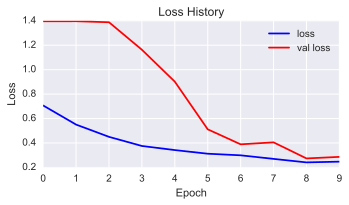

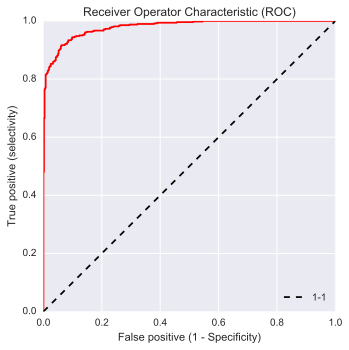

In [51]:
# ------------------------------------------------------------------------------
# Analyze
# ------------------------------------------------------------------------------

# History
hist = history.history
loss = hist['loss']
val_loss = hist["val_loss"]
epochs = np.arange(nb_epoch)
figsize=(5,3)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_loss = axis1.plot(epochs, loss, 'b', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'r', label="val loss")
plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss')
plt.title("Loss History")
plt.tight_layout()
axis1.legend(loc='upper right')

# ROC
figsize=(5,5)
fig, axis1 = plt.subplots(figsize=figsize)
x_onetoone = y_onetoone = [0, 1]
#label_roc = "ROC, AUC = " + auc if auc is not None else "ROC"
plt.plot(fpr, tpr, 'r-')#,  label=label_roc)
plt.plot(x_onetoone, y_onetoone, 'k--',  label="1-1")
plt.legend(loc=0)
plt.title("Receiver Operator Characteristic (ROC)")
plt.xlabel("False positive (1 - Specificity)")
plt.ylabel("True positive (selectivity)")
plt.tight_layout()


# plot variety of filters for a given image


# print out CM cleanly


16 (16, 16) (16, 16)


NameError: global name 'cmap' is not defined

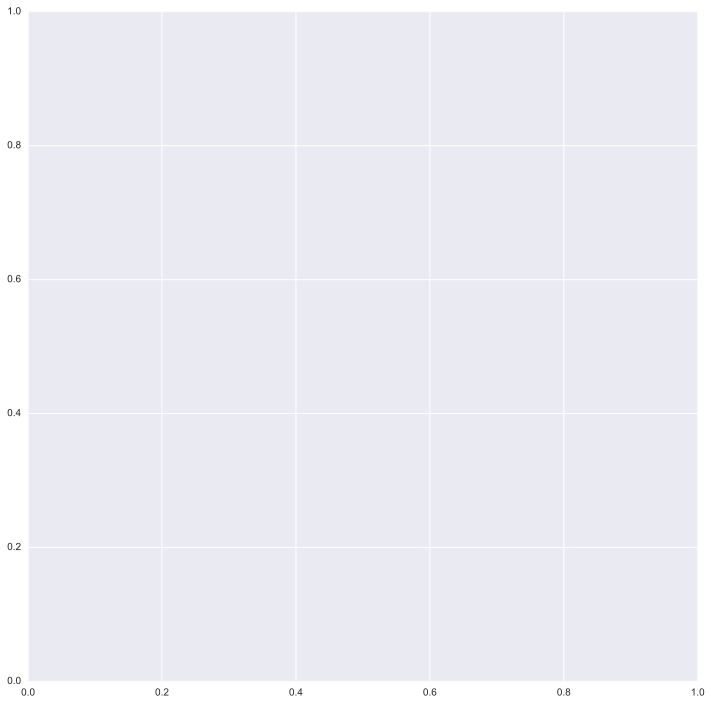

In [81]:
layers = get_layers(model, x_valid, "test",
                 ind_layer_in=1,
                 ind_layer_out=1)
plot_layer_filter_panel(layers[0], 0)